### About research
Creating an ML model that forecasts the price movement in the order book. This article contains a full-cycle of research: getting data, visualization, feature engineering, modeling, fine-tuning of the algorithm, quality estimation, and so on.

In [67]:
import pandas as pd
import numpy as np
import itertools
from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_error
import scipy.stats
from hyperopt import hp, tpe, fmin, Trials, STATUS_OK
from hyperopt.pyll.base import scope
import seaborn as sns
from matplotlib import cm, pyplot as plt
from scipy import stats as st
from sklearn.utils import resample

sns.set()

### Loading data and Feature engineering functions

In [71]:
def load_data(asset, level):
    data = pd.read_csv('./data/{0}_2012-06-21_34200000_57600000_orderbook_{1}.csv'.format(asset, level), header=None)
    
    levels = list(range(1, level + 1))
    iters = [iter(levels), iter(levels), iter(levels), iter(levels)]
    abv = ['ask', 'volume_ask', 'bid', 'volume_bid'] * level
    nums = [x for x in itertools.chain.from_iterable(itertools.zip_longest(levels, levels, levels, levels)) if x]
    data.columns = list(map(lambda x, y: '{0}_{1}'.format(x, y), abv, nums))
    
    return data

def feature_engineering(ds, level, num_lags):
    out_ds = pd.DataFrame()
    
    for i in range(1, level + 1):
        out_ds['log_return_ask_{0}'.format(i)] = np.log(ds['ask_{0}'.format(i)].pct_change() + 1)
        out_ds['log_return_bid_{0}'.format(i)] = np.log(ds['bid_{0}'.format(i)].pct_change() + 1)
        
        out_ds['log_ask_{0}_div_bid_{0}'.format(i)] = np.log(ds['ask_{0}'.format(i)] / ds['bid_{0}'.format(i)])
        out_ds['log_volume_ask_{0}_div_bid_{0}'.format(i)] = np.log(ds['volume_ask_{0}'.format(i)] / ds['volume_bid_{0}'.format(i)])
        
        out_ds['log_volume_ask_{0}'.format(i)] = np.log(ds['volume_ask_{0}'.format(i)])
        out_ds['log_volume_bid_{0}'.format(i)] = np.log(ds['volume_bid_{0}'.format(i)])
        
        if i != 1:
            out_ds['log_ask_{0}_div_ask_1'.format(i)] = np.log(ds['ask_{0}'.format(i)] / ds['ask_1'])
            out_ds['log_bid_{0}_div_bid_1'.format(i)] = np.log(ds['bid_{0}'.format(i)] / ds['bid_1'])
            out_ds['log_volume_ask_{0}_div_ask_1'.format(i)] = np.log(ds['volume_ask_{0}'.format(i)] / ds['volume_ask_1'])
            out_ds['log_volume_bid_{0}_div_bid_1'.format(i)] = np.log(ds['volume_bid_{0}'.format(i)] / ds['volume_bid_1'])
        
    out_ds['log_total_volume_ask'] = np.log(ds[['volume_ask_{0}'.format(x) for x in list(range(1, level + 1))]].sum(axis = 1))
    out_ds['log_total_volume_bid'] = np.log(ds[['volume_bid_{0}'.format(x) for x in list(range(1, level + 1))]].sum(axis = 1))
            
    mid_price = (ds['ask_1'] + ds['bid_1']) / 2
    out_ds['log_return_mid_price'] = np.log(mid_price.pct_change() + 1).shift(-1)
        
    cols_features = out_ds.columns.drop(target_column)
    out_ds = out_ds.assign(**{
        '{}_(t-{})'.format(col, t): out_ds[col].shift(t)
        for t in list(range(1, num_lags))
        for col in cols_features})
    
    return out_ds.dropna()

In [4]:
target_column = 'log_return_mid_price'

### Test load_data and feature_engineering functions

In [81]:
source_data = load_data('AAPL', 1)
dataset = feature_engineering(source_data, 1, 1)

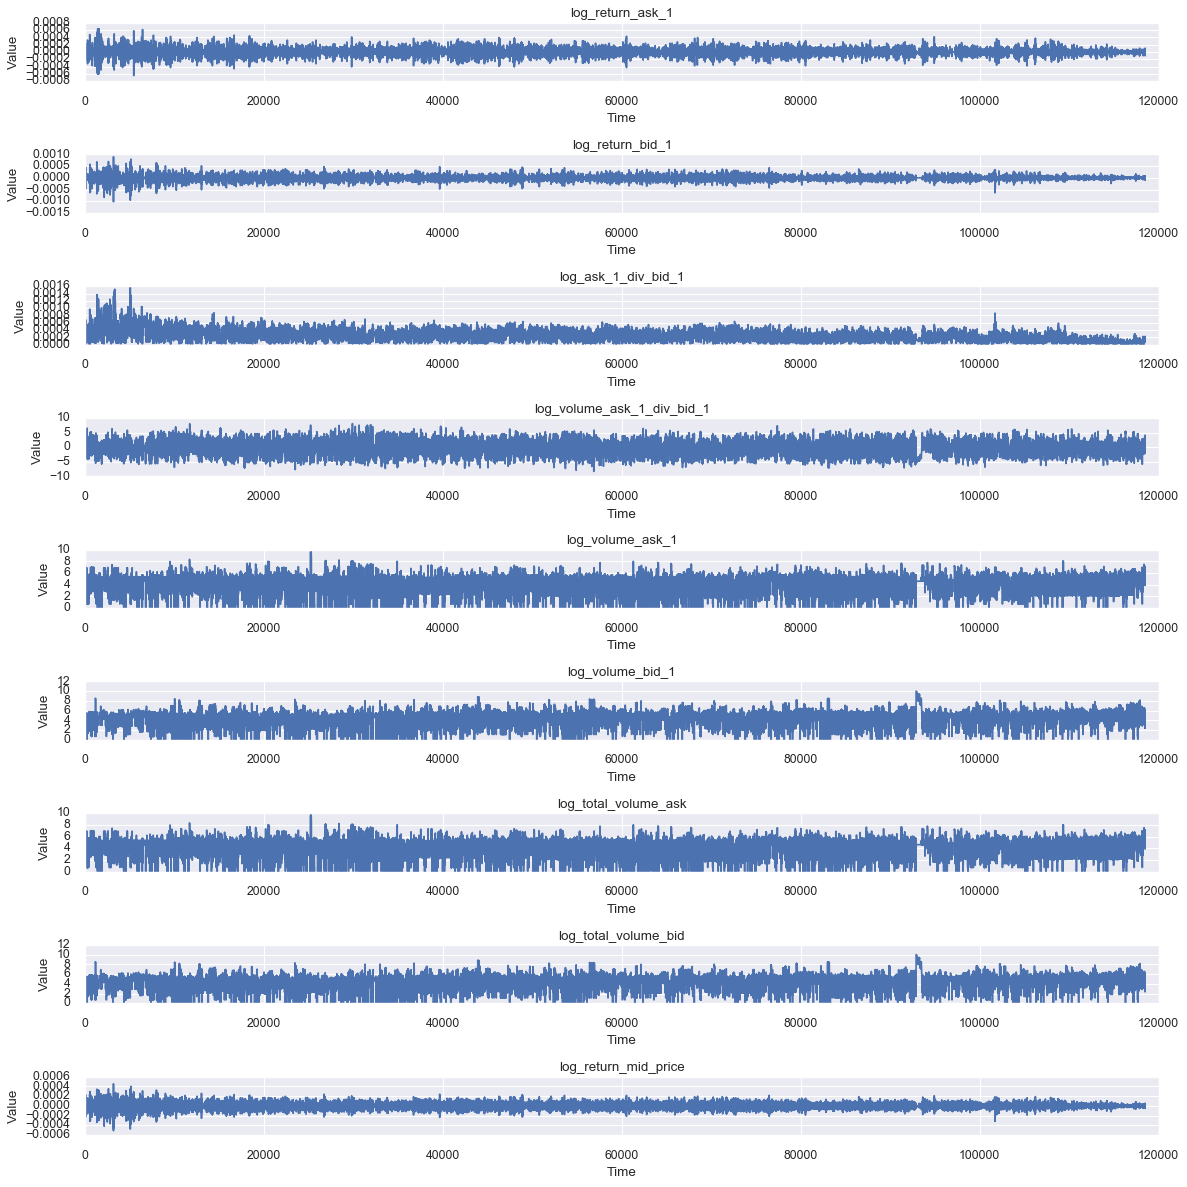

In [93]:
fig, axs = plt.subplots(len(dataset.columns), 1, figsize = (15, 15))
for i in range(0, len(dataset.columns)):
    c = dataset.columns[i]
    
    axs[i].plot(dataset[c])
    axs[i].set_title(c)
    axs[i].set_xlabel('Time')
    axs[i].set_ylabel('Value')
plt.tight_layout()
plt.show()

### Let's plot mid-price and difference of ask-bid volumes

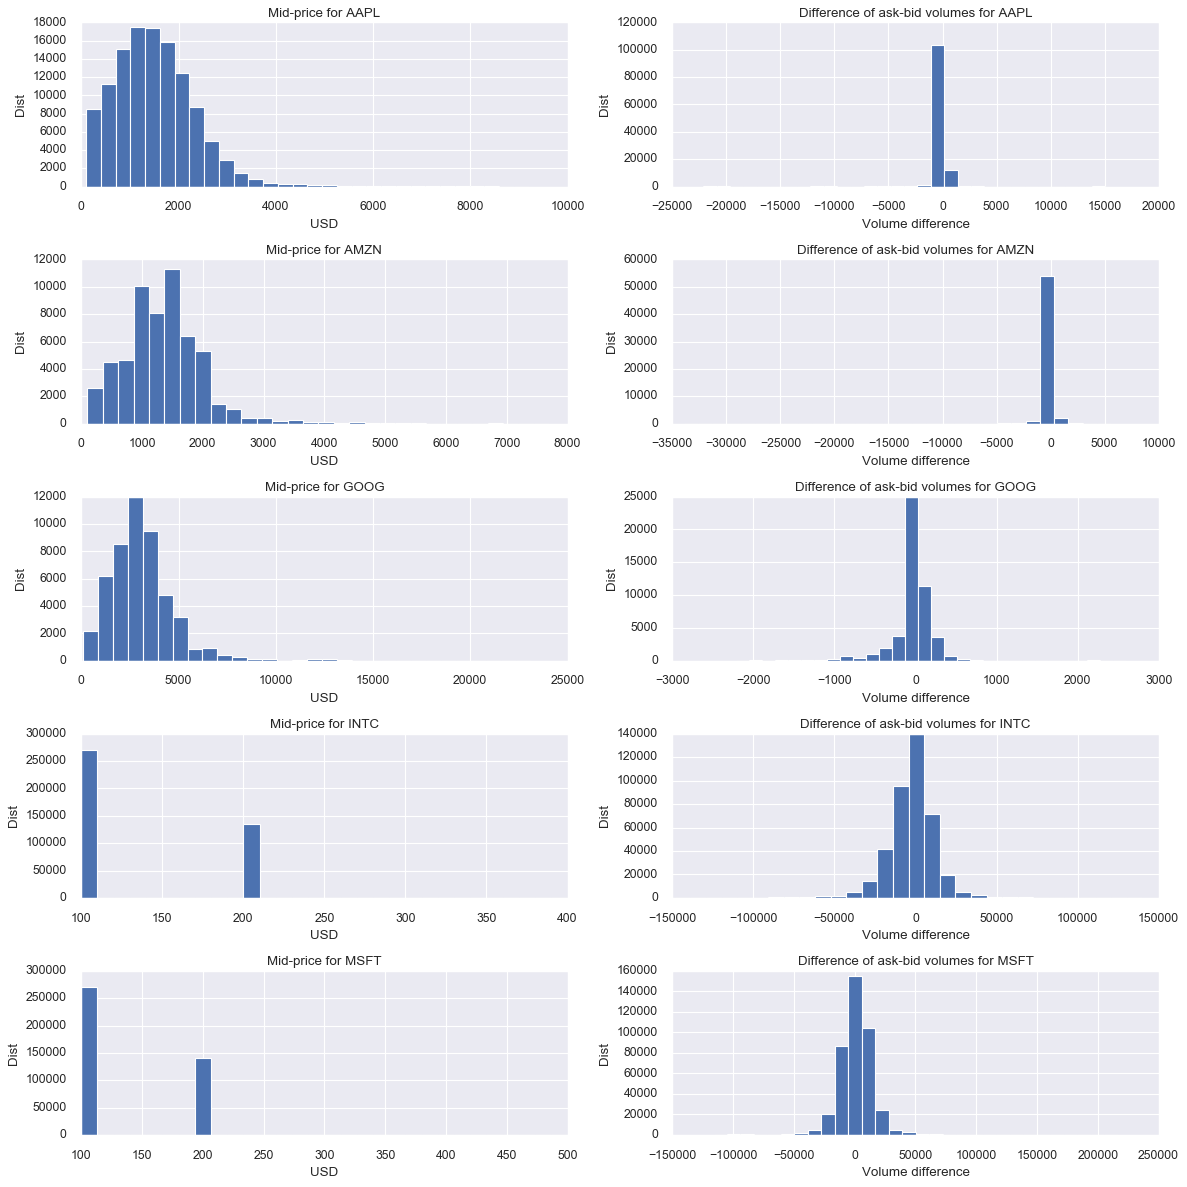

In [68]:
assets = ['AAPL', 'AMZN', 'GOOG', 'INTC', 'MSFT']
fig, axs = plt.subplots(len(assets), 2, figsize = (15, 15))
colours = cm.prism(np.linspace(0, 1, len(assets)))

for i, (ax, colour) in enumerate(zip(axs, colours)):
    asset = assets[i]
    source_data = load_data(asset, 1)
    diff_volumes = source_data.volume_ask_1 - source_data.volume_bid_1
    mid_price = source_data.ask_1 - source_data.bid_1
    
    ax[0].hist(mid_price[~np.isnan(mid_price)], bins = 30)
    ax[0].set_title('Mid-price for ' + asset)
    ax[0].set_xlabel('USD')
    ax[0].set_ylabel('Dist')
    
    ax[1].hist(diff_volumes[~np.isnan(diff_volumes)], bins = 30)
    ax[1].set_title('Difference of ask-bid volumes for ' + asset)
    ax[1].set_xlabel('Volume difference')
    ax[1].set_ylabel('Dist')
    
plt.tight_layout()

### Main functions
bs_interval - the function that carries out the estimation of bootstrapped interval of errors.

objective - function that used for optimization step by hyperopt library.

do_experiment - splitting data on the train/valid/test, optimization, fitting the final model, and quality estimation.

In [5]:
def bs_interval(arr, num_bs_size = 10000, num_elements_mean = 1000, alpha = 0.05):
    bs = list()
    for i in range(0, num_bs_size):
        bs.append(np.mean(resample(arr, n_samples = num_elements_mean)))
        
    return st.t.interval(1 - alpha, len(bs) - 1, loc = np.mean(bs), scale = st.sem(bs))

def objective(hyper_params):
    print(hyper_params)
    
    source_data = load_data(hyper_params['asset_name'], hyper_params['level'])
    dataset = feature_engineering(source_data, hyper_params['level'], int(hyper_params['num_lags']))
    
    start_valid_ind = int(dataset.shape[0] * 0.5)
    start_test_ind = int(dataset.shape[0] * 0.75)
    train_ds = dataset[:start_valid_ind]
    valid_ds = dataset[start_valid_ind:start_test_ind]
    
    regr = CatBoostRegressor(n_estimators = hyper_params['n_estimators'], thread_count=3, task_type = 'CPU',
                             learning_rate = hyper_params['learning_rate'], depth = hyper_params['depth'],
                             l2_leaf_reg = hyper_params['l2_leaf_reg'], loss_function = 'RMSE')
    
    regr.fit(train_ds[train_ds.columns.drop(target_column)], train_ds[target_column],
             use_best_model = True, logging_level = 'Silent',
             eval_set = (valid_ds[valid_ds.columns.drop(target_column)], valid_ds[target_column]))

    predictions = regr.predict(valid_ds[valid_ds.columns.drop(target_column)])
    result = mean_squared_error(valid_ds[target_column], predictions)
    
    print('Objective function value on validation set: ' + str(result))
    return result

def do_experiment(asset_name):
    levels = [1, 5, 10]
    const_params = {'asset_name': asset_name}
    hyper_params_space = {'level': hp.choice('level', levels),
                          'num_lags': hp.quniform('num_lags', 1, 10, 1),
                          'n_estimators': hp.quniform('n_estimators', 50, 500, 5),
                          'depth': hp.quniform('depth', 1, 10, 1),
                          'learning_rate': hp.uniform('learning_rate', 0.05, 1.0),
                          'l2_leaf_reg':  hp.uniform('l2_leaf_reg', 0.01, 30.0)}
    
    hyper_params_space.update(const_params)
    
    tpe_trials = Trials()
    opt_params = fmin(
        fn = objective,
        space = hyper_params_space,
        algo = tpe.suggest,
        max_evals = 30,
        trials = tpe_trials,
        rstate = np.random.RandomState(100))
    
    opt_params.update(const_params)
    opt_params['level'] = levels[opt_params['level']]
    print('Best parameters:')
    print(opt_params)
    
    source_data = load_data(asset_name, opt_params['level'])
    print('Input data shape is {0}'.format(source_data.shape))
    print(source_data.head())
    
    dataset = feature_engineering(source_data, opt_params['level'], int(opt_params['num_lags']))
    print('Dataset shape is {0}'.format(dataset.shape))
    print(dataset.head())
    
    '''
    for c in dataset.columns:
        plt.figure(figsize=(15, 10))
        plt.plot(dataset[c])
        plt.title(c)
        plt.xlabel('Time')
        plt.ylabel('Value')
        plt.show()
    '''
    start_test_ind = int(dataset.shape[0] * 0.75)
    train_ds = dataset[:start_test_ind]
    test_ds = dataset[start_test_ind:]
    
    regr = CatBoostRegressor(n_estimators = opt_params['n_estimators'], thread_count=3, task_type = 'CPU',
                             learning_rate = opt_params['learning_rate'], depth = opt_params['depth'],
                             l2_leaf_reg = opt_params['l2_leaf_reg'], loss_function = 'RMSE')
    
    regr.fit(train_ds[train_ds.columns.drop(target_column)], train_ds[target_column],
         use_best_model = False, logging_level = 'Silent')
    
    fi = pd.DataFrame({'feature': regr.feature_names_, 'importance': regr.feature_importances_})
    plt.figure(figsize=(15, 10))
    plt.barh(fi.feature, fi.importance)
    plt.title('Feature importances')
    plt.show()

    print('Feature importances table:')
    print(fi.sort_values('importance', ascending = False))
    
    predictions = regr.predict(test_ds[test_ds.columns.drop(target_column)])
    baseline_mse = np.array((test_ds[target_column] - np.zeros_like(test_ds[target_column])) ** 2)
    modeling_mse = np.array((test_ds[target_column] - predictions) ** 2)
    
    print('MSE on test set: ' + str(mean_squared_error(test_ds[target_column], predictions)))
    print('Confidence interval of MSE for baseline: ' + str(bs_interval(baseline_mse)))
    print('Confidence interval of MSE for modeling: ' + str(bs_interval(modeling_mse)))
    
    plt.figure(figsize=(15, 10))
    plt.scatter(test_ds[target_column], predictions)
    plt.title('True returns and Predictions scatter plot')
    plt.xlabel('True returns')
    plt.ylabel('Predictions')
    plt.show()

{'asset_name': 'GOOG', 'depth': 8.0, 'l2_leaf_reg': 9.559870126300055, 'learning_rate': 0.820242773021529, 'level': 5, 'n_estimators': 160.0, 'num_lags': 4.0}
Objective function value on validation set: 8.006691721650647e-10
{'asset_name': 'GOOG', 'depth': 3.0, 'l2_leaf_reg': 27.855889188938363, 'learning_rate': 0.16893633551130577, 'level': 10, 'n_estimators': 125.0, 'num_lags': 5.0}
Objective function value on validation set: 5.961128123683016e-10
{'asset_name': 'GOOG', 'depth': 6.0, 'l2_leaf_reg': 24.006917794538648, 'learning_rate': 0.3643657415946367, 'level': 5, 'n_estimators': 235.0, 'num_lags': 4.0}
Objective function value on validation set: 7.935579509925861e-10
{'asset_name': 'GOOG', 'depth': 2.0, 'l2_leaf_reg': 12.141070152786279, 'learning_rate': 0.2046503426057844, 'level': 10, 'n_estimators': 295.0, 'num_lags': 5.0}
Objective function value on validation set: 5.947179565437356e-10
{'asset_name': 'GOOG', 'depth': 5.0, 'l2_leaf_reg': 28.599847611580095, 'learning_rate': 0.

Dataset shape is (147907, 785)
    log_return_ask_1  log_return_bid_1  log_ask_1_div_bid_1  \
8           0.000000               0.0             0.001431   
9           0.000000               0.0             0.001431   
10         -0.000586               0.0             0.000845   
11          0.000000               0.0             0.000845   
12          0.000000               0.0             0.000845   

    log_volume_ask_1_div_bid_1  log_volume_ask_1  log_volume_bid_1  \
8                    -0.254642          4.605170          4.859812   
9                    -0.254642          4.605170          4.859812   
10                   -1.640937          3.218876          4.859812   
11                   -1.640937          3.218876          4.859812   
12                   -1.640937          3.218876          4.859812   

    log_total_volume_ask  log_total_volume_bid  log_return_mid_price  \
8               6.856462              7.625107              0.000000   
9               6.856462 

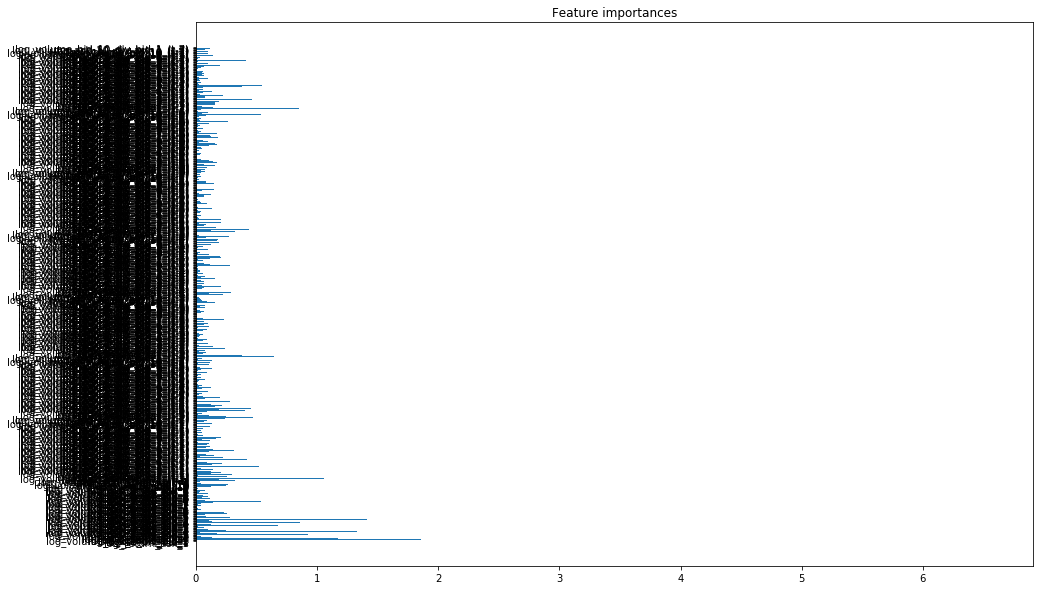

Feature importances table:
                               feature  importance
1                     log_return_bid_1    6.579405
0                     log_return_ask_1    3.651435
14                 log_ask_2_div_ask_1    3.006680
9                     log_return_bid_2    2.687472
2                  log_ask_1_div_bid_1    1.861382
34                 log_ask_4_div_ask_1    1.409996
15                 log_bid_2_div_bid_1    1.331035
4                     log_volume_ask_1    1.171770
99              log_return_bid_1_(t-1)    1.056087
25                 log_bid_3_div_bid_1    1.035789
100          log_ask_1_div_bid_1_(t-1)    0.967733
10                 log_ask_2_div_bid_2    0.923576
52                    log_volume_ask_6    0.878600
382            log_return_ask_10_(t-3)    0.865138
29                    log_return_bid_4    0.856918
686             log_return_ask_1_(t-7)    0.853817
98              log_return_ask_1_(t-1)    0.822453
112          log_ask_2_div_ask_1_(t-1)    0.777853
74  

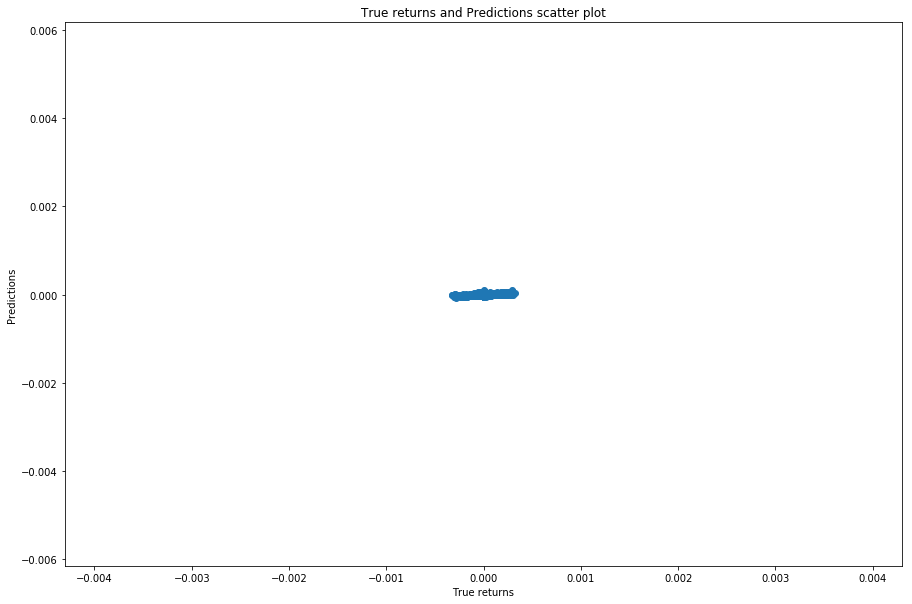

In [5]:
do_experiment('GOOG')

{'asset_name': 'AAPL', 'depth': 8.0, 'l2_leaf_reg': 9.559870126300055, 'learning_rate': 0.820242773021529, 'level': 5, 'n_estimators': 160.0, 'num_lags': 4.0}
Objective function value on validation set: 2.7882619506958736e-10
{'asset_name': 'AAPL', 'depth': 3.0, 'l2_leaf_reg': 27.855889188938363, 'learning_rate': 0.16893633551130577, 'level': 10, 'n_estimators': 125.0, 'num_lags': 5.0}
Objective function value on validation set: 1.9944900870261307e-10
{'asset_name': 'AAPL', 'depth': 6.0, 'l2_leaf_reg': 24.006917794538648, 'learning_rate': 0.3643657415946367, 'level': 5, 'n_estimators': 235.0, 'num_lags': 4.0}
Objective function value on validation set: 2.719064986476811e-10
{'asset_name': 'AAPL', 'depth': 2.0, 'l2_leaf_reg': 12.141070152786279, 'learning_rate': 0.2046503426057844, 'level': 10, 'n_estimators': 295.0, 'num_lags': 5.0}
Objective function value on validation set: 1.983698578386668e-10
{'asset_name': 'AAPL', 'depth': 5.0, 'l2_leaf_reg': 28.599847611580095, 'learning_rate': 

Dataset shape is (400382, 785)
    log_return_ask_1  log_return_bid_1  log_ask_1_div_bid_1  \
8           0.000000               0.0             0.000990   
9           0.000000               0.0             0.000990   
10          0.000017               0.0             0.001007   
11          0.000000               0.0             0.001007   
12          0.000017               0.0             0.001025   

    log_volume_ask_1_div_bid_1  log_volume_ask_1  log_volume_bid_1  \
8                     0.000000          2.890372          2.890372   
9                     0.000000          2.890372          2.890372   
10                    0.000000          2.890372          2.890372   
11                    0.000000          2.890372          2.890372   
12                    1.714798          4.605170          2.890372   

    log_total_volume_ask  log_total_volume_bid  log_return_mid_price  \
8               7.101676              7.158514              0.000000   
9               7.101676 

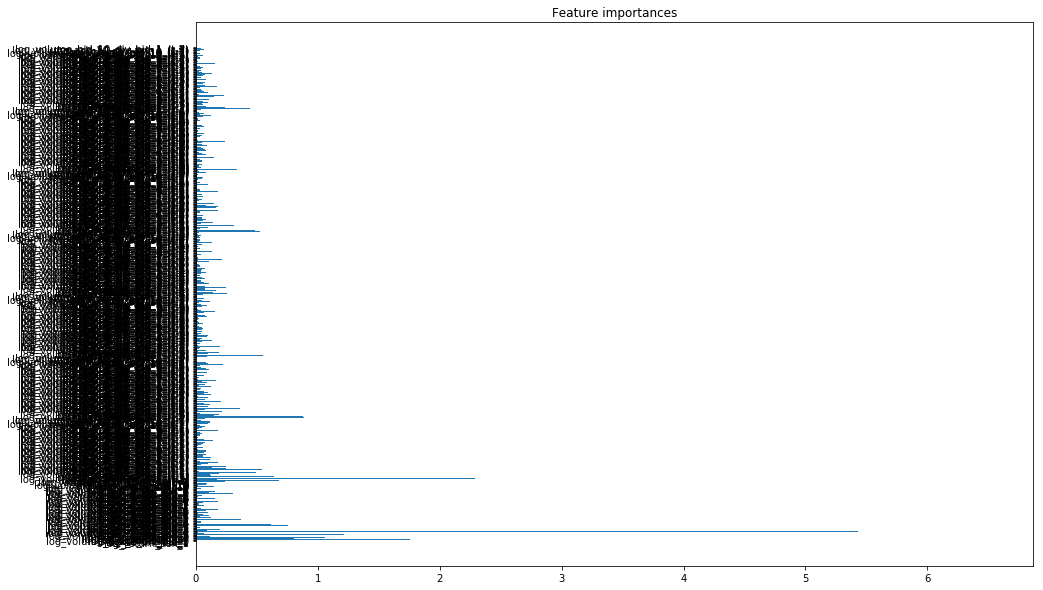

Feature importances table:
                              feature  importance
1                    log_return_bid_1    6.539178
0                    log_return_ask_1    5.892136
14                log_ask_2_div_ask_1    5.814804
15                log_bid_2_div_bid_1    5.431070
99             log_return_bid_1_(t-1)    2.289579
2                 log_ask_1_div_bid_1    1.755596
98             log_return_ask_1_(t-1)    1.674578
10                log_ask_2_div_bid_2    1.210644
8                    log_return_ask_2    1.078574
5                    log_volume_bid_1    1.058332
9                    log_return_bid_2    1.037920
196            log_return_ask_1_(t-2)    0.882402
197            log_return_bid_1_(t-2)    0.881961
4                    log_volume_ask_1    0.804369
24                log_ask_3_div_ask_1    0.754148
3          log_volume_ask_1_div_bid_1    0.734172
96        log_volume_ask_10_div_ask_1    0.682533
111            log_volume_bid_2_(t-1)    0.666028
66         log_volume_a

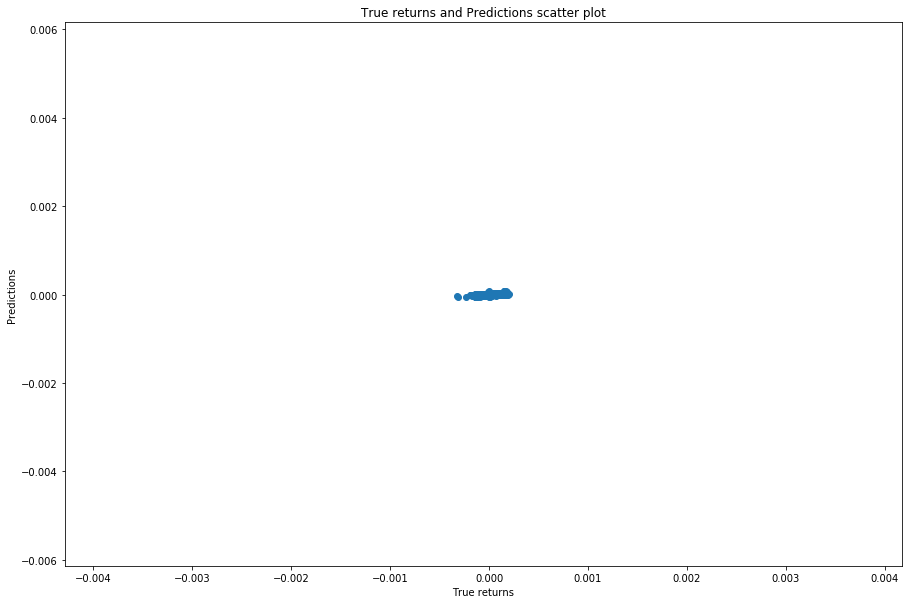

In [6]:
do_experiment('AAPL')

{'asset_name': 'AMZN', 'depth': 8.0, 'l2_leaf_reg': 9.559870126300055, 'learning_rate': 0.820242773021529, 'level': 5, 'n_estimators': 160.0, 'num_lags': 4.0}
Objective function value on validation set: 1.017238902011562e-09
{'asset_name': 'AMZN', 'depth': 3.0, 'l2_leaf_reg': 27.855889188938363, 'learning_rate': 0.16893633551130577, 'level': 10, 'n_estimators': 125.0, 'num_lags': 5.0}
Objective function value on validation set: 5.427681267654899e-10
{'asset_name': 'AMZN', 'depth': 6.0, 'l2_leaf_reg': 24.006917794538648, 'learning_rate': 0.3643657415946367, 'level': 5, 'n_estimators': 235.0, 'num_lags': 4.0}
Objective function value on validation set: 1.005447903791715e-09
{'asset_name': 'AMZN', 'depth': 2.0, 'l2_leaf_reg': 12.141070152786279, 'learning_rate': 0.2046503426057844, 'level': 10, 'n_estimators': 295.0, 'num_lags': 5.0}
Objective function value on validation set: 5.407882144873573e-10
{'asset_name': 'AMZN', 'depth': 5.0, 'l2_leaf_reg': 28.599847611580095, 'learning_rate': 0.

Dataset shape is (269739, 785)
    log_return_ask_1  log_return_bid_1  log_ask_1_div_bid_1  \
8                0.0               0.0             0.000625   
9                0.0               0.0             0.000625   
10               0.0               0.0             0.000625   
11               0.0               0.0             0.000625   
12               0.0               0.0             0.000625   

    log_volume_ask_1_div_bid_1  log_volume_ask_1  log_volume_bid_1  \
8                     1.560648           4.60517          3.044522   
9                     1.560648           4.60517          3.044522   
10                    1.560648           4.60517          3.044522   
11                    1.560648           4.60517          3.044522   
12                    1.560648           4.60517          3.044522   

    log_total_volume_ask  log_total_volume_bid  log_return_mid_price  \
8               7.380256              8.444192                   0.0   
9               7.380256 

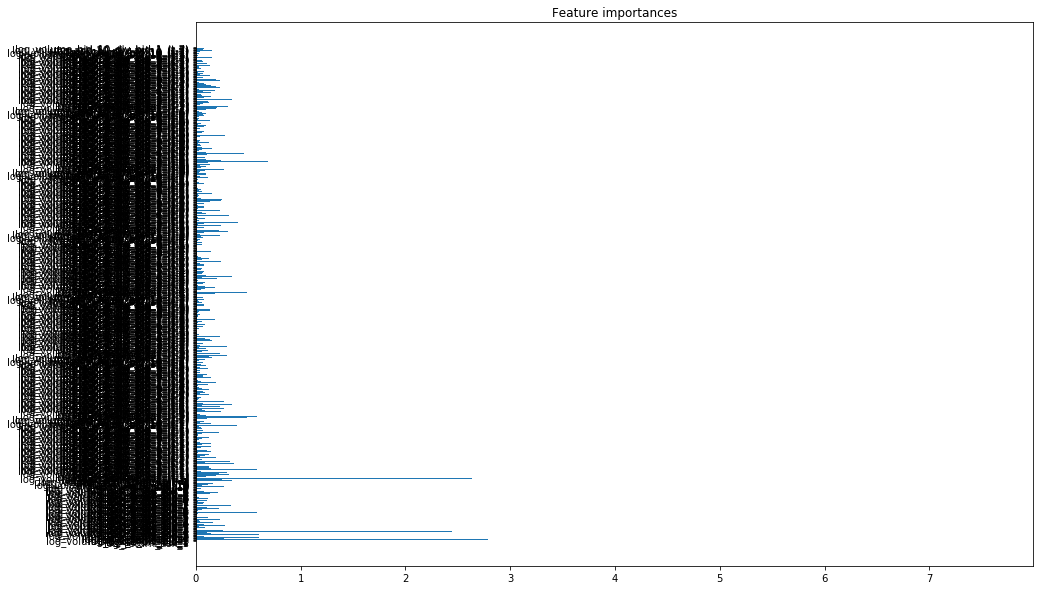

Feature importances table:
                              feature  importance
1                    log_return_bid_1    7.609319
0                    log_return_ask_1    3.518660
2                 log_ask_1_div_bid_1    2.791284
99             log_return_bid_1_(t-1)    2.632959
15                log_bid_2_div_bid_1    2.448633
14                log_ask_2_div_ask_1    2.230668
98             log_return_ask_1_(t-1)    1.208540
295            log_return_bid_1_(t-3)    1.059808
25                log_bid_3_div_bid_1    0.859586
198         log_ask_1_div_bid_1_(t-2)    0.770751
309         log_bid_2_div_bid_1_(t-3)    0.757012
8                    log_return_ask_2    0.726284
602         log_ask_2_div_ask_1_(t-6)    0.686255
5                    log_volume_bid_1    0.606334
10                log_ask_2_div_bid_2    0.600541
45                log_bid_5_div_bid_1    0.583762
113         log_bid_2_div_bid_1_(t-1)    0.580883
197            log_return_bid_1_(t-2)    0.579020
710         log_ask_3_d

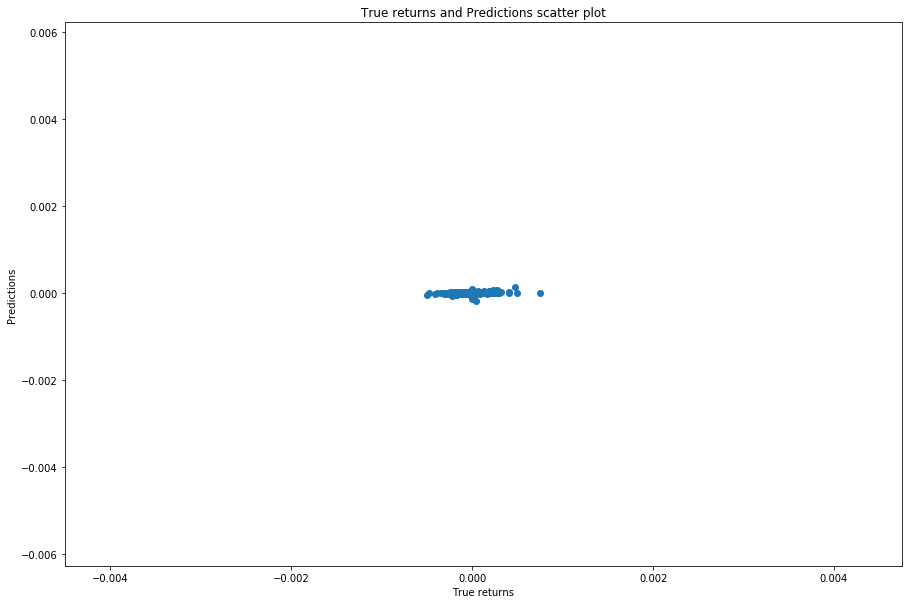

In [7]:
do_experiment('AMZN')

{'asset_name': 'INTC', 'depth': 8.0, 'l2_leaf_reg': 9.559870126300055, 'learning_rate': 0.820242773021529, 'level': 5, 'n_estimators': 160.0, 'num_lags': 4.0}
Objective function value on validation set: 1.1913094163707512e-10
{'asset_name': 'INTC', 'depth': 3.0, 'l2_leaf_reg': 27.855889188938363, 'learning_rate': 0.16893633551130577, 'level': 10, 'n_estimators': 125.0, 'num_lags': 5.0}
Objective function value on validation set: 1.0512220864731307e-10
{'asset_name': 'INTC', 'depth': 6.0, 'l2_leaf_reg': 24.006917794538648, 'learning_rate': 0.3643657415946367, 'level': 5, 'n_estimators': 235.0, 'num_lags': 4.0}
Objective function value on validation set: 1.0920293799323251e-10
{'asset_name': 'INTC', 'depth': 2.0, 'l2_leaf_reg': 12.141070152786279, 'learning_rate': 0.2046503426057844, 'level': 10, 'n_estimators': 295.0, 'num_lags': 5.0}
Objective function value on validation set: 1.0478206435459013e-10
{'asset_name': 'INTC', 'depth': 5.0, 'l2_leaf_reg': 28.599847611580095, 'learning_rate'

Dataset shape is (624031, 785)
    log_return_ask_1  log_return_bid_1  log_ask_1_div_bid_1  \
8                0.0               0.0             0.000363   
9                0.0               0.0             0.000363   
10               0.0               0.0             0.000363   
11               0.0               0.0             0.000363   
12               0.0               0.0             0.000363   

    log_volume_ask_1_div_bid_1  log_volume_ask_1  log_volume_bid_1  \
8                    -0.591795          5.111988          5.703782   
9                    -0.591795          5.111988          5.703782   
10                   -0.591795          5.111988          5.703782   
11                   -0.591795          5.111988          5.703782   
12                   -0.591795          5.111988          5.703782   

    log_total_volume_ask  log_total_volume_bid  log_return_mid_price  \
8               9.531481              9.569692                   0.0   
9               9.531481 

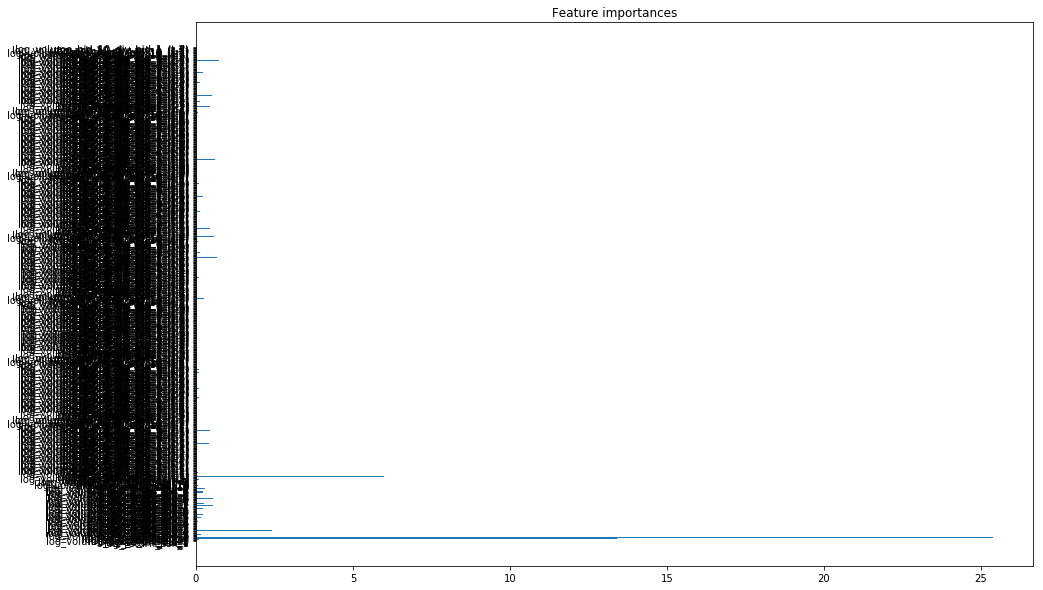

Feature importances table:
                                feature  importance
5                      log_volume_bid_1   25.382303
4                      log_volume_ask_1   13.409803
103              log_volume_bid_1_(t-1)   12.996606
412           log_ask_3_div_bid_3_(t-4)    9.677711
102              log_volume_ask_1_(t-1)    5.995119
396              log_volume_ask_1_(t-4)    2.600275
16           log_volume_ask_2_div_ask_1    2.425116
3            log_volume_ask_1_div_bid_1    1.430292
469    log_volume_bid_8_div_bid_1_(t-4)    1.180245
201              log_volume_bid_1_(t-2)    1.164761
298              log_volume_ask_1_(t-3)    1.015057
598           log_ask_2_div_bid_2_(t-6)    0.908022
17           log_volume_bid_2_div_bid_1    0.878938
782   log_volume_ask_10_div_ask_1_(t-7)    0.799465
762    log_volume_ask_8_div_ask_1_(t-7)    0.737489
449    log_volume_bid_6_div_bid_1_(t-4)    0.670399
1                      log_return_bid_1    0.659967
605    log_volume_bid_2_div_bid_1_(t-

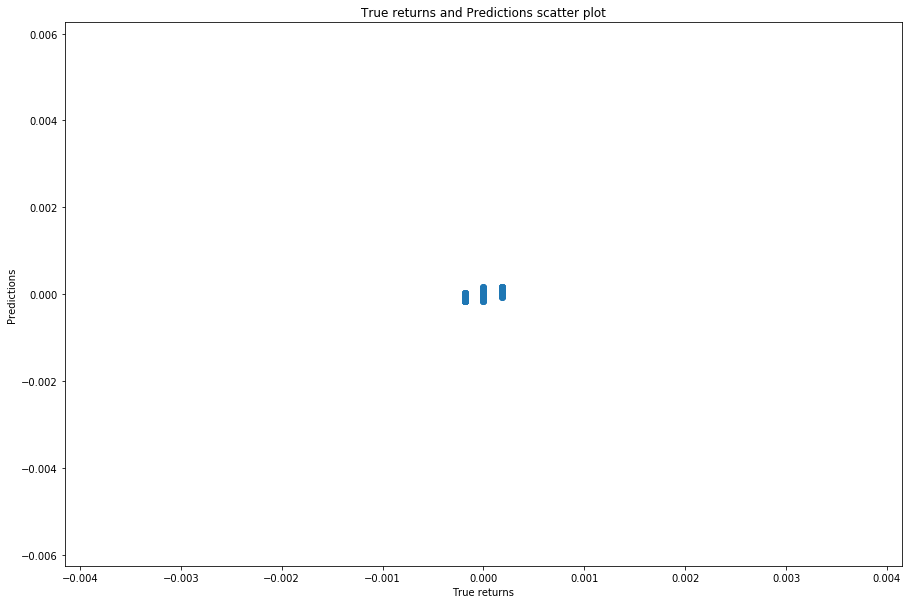

In [8]:
do_experiment('INTC')

{'asset_name': 'MSFT', 'depth': 8.0, 'l2_leaf_reg': 9.559870126300055, 'learning_rate': 0.820242773021529, 'level': 5, 'n_estimators': 160.0, 'num_lags': 4.0}
Objective function value on validation set: 1.2884882074004493e-10
{'asset_name': 'MSFT', 'depth': 3.0, 'l2_leaf_reg': 27.855889188938363, 'learning_rate': 0.16893633551130577, 'level': 10, 'n_estimators': 125.0, 'num_lags': 5.0}
Objective function value on validation set: 1.1813003857882524e-10
{'asset_name': 'MSFT', 'depth': 6.0, 'l2_leaf_reg': 24.006917794538648, 'learning_rate': 0.3643657415946367, 'level': 5, 'n_estimators': 235.0, 'num_lags': 4.0}
Objective function value on validation set: 1.2864247884117848e-10
{'asset_name': 'MSFT', 'depth': 2.0, 'l2_leaf_reg': 12.141070152786279, 'learning_rate': 0.2046503426057844, 'level': 10, 'n_estimators': 295.0, 'num_lags': 5.0}
Objective function value on validation set: 1.1773389481515354e-10
{'asset_name': 'MSFT', 'depth': 5.0, 'l2_leaf_reg': 28.599847611580095, 'learning_rate'

Dataset shape is (668755, 883)
    log_return_ask_1  log_return_bid_1  log_ask_1_div_bid_1  \
9                0.0               0.0             0.001292   
10               0.0               0.0             0.001292   
11               0.0               0.0             0.001292   
12               0.0               0.0             0.001292   
13               0.0               0.0             0.001292   

    log_volume_ask_1_div_bid_1  log_volume_ask_1  log_volume_bid_1  \
9                     2.535811          8.239593          5.703782   
10                    2.535811          8.239593          5.703782   
11                    2.535811          8.239593          5.703782   
12                    2.535811          8.239593          5.703782   
13                    2.535811          8.239593          5.703782   

    log_total_volume_ask  log_total_volume_bid  log_return_mid_price  \
9               9.958733               8.93406                   0.0   
10              9.934792 

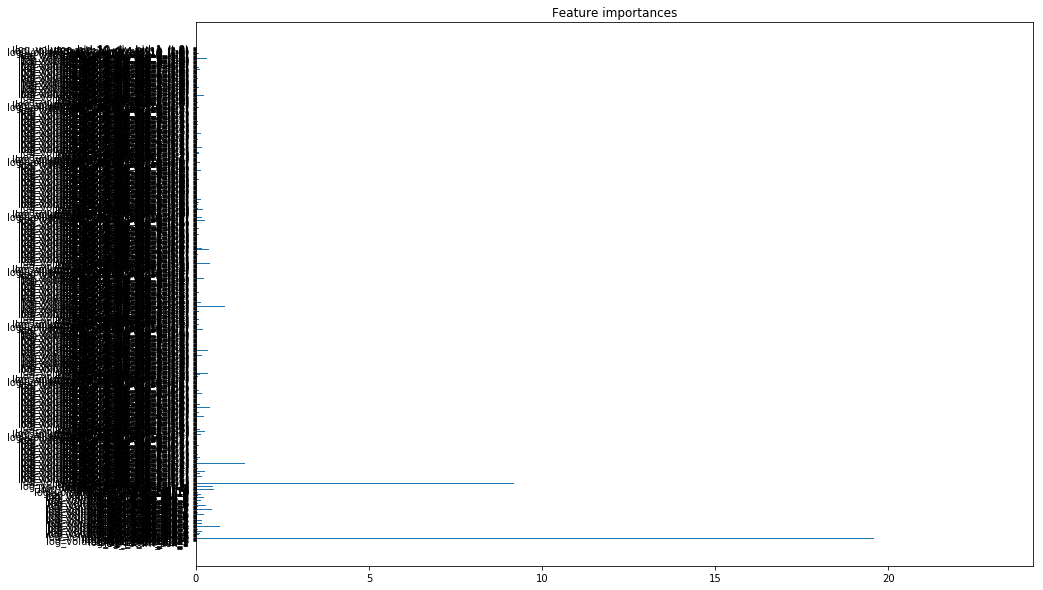

Feature importances table:
                               feature  importance
5                     log_volume_bid_1   23.027877
4                     log_volume_ask_1   19.601665
102             log_volume_ask_1_(t-1)    9.182609
103             log_volume_bid_1_(t-1)    7.950654
138          log_ask_5_div_bid_5_(t-1)    1.419645
794          log_ask_2_div_bid_2_(t-8)    1.195732
27          log_volume_bid_3_div_bid_1    1.108737
134   log_volume_ask_4_div_ask_1_(t-1)    1.046773
418   log_volume_ask_3_div_ask_1_(t-4)    0.851136
100          log_ask_1_div_bid_1_(t-1)    0.715406
26          log_volume_ask_3_div_ask_1    0.684584
57          log_volume_bid_6_div_bid_1    0.588767
587  log_volume_bid_10_div_bid_1_(t-5)    0.564003
16          log_volume_ask_2_div_ask_1    0.528652
46          log_volume_ask_5_div_ask_1    0.519317
92                   log_volume_ask_10    0.513022
298             log_volume_ask_1_(t-3)    0.494150
97         log_volume_bid_10_div_bid_1    0.489050
56  

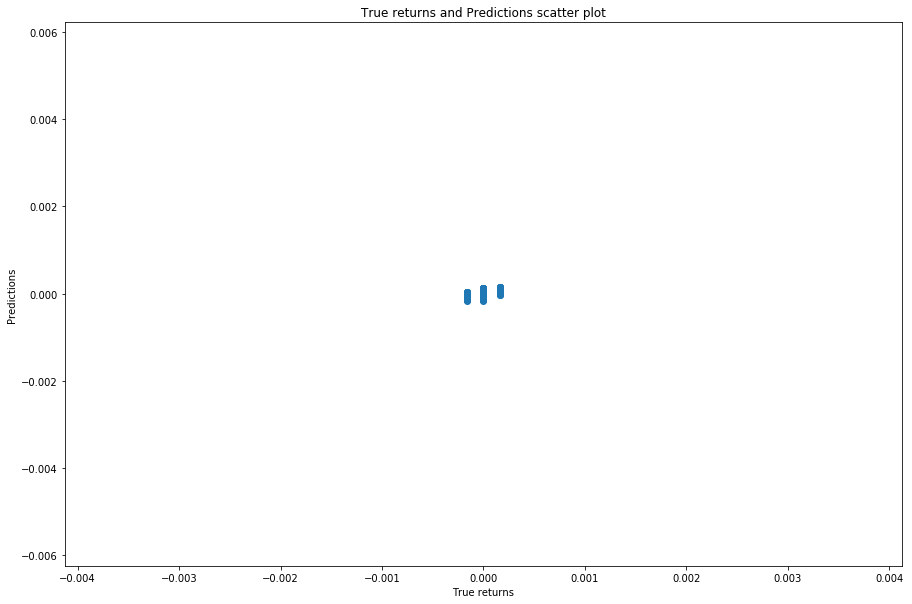

In [6]:
do_experiment('MSFT')